In [8]:
import sasktran2 as sk
import numpy as np
import xarray as xr
import seaborn as sns
import pylidort
import matplotlib.pyplot as plt

colors = sns.color_palette('colorblind')

def time_sk2(nlyr, nstr, deriv=False):

    cos_sza = 0.6

    top_alt = 100001
    tau = 1

    config = sk.Config()
    config.multiple_scatter_source = sk.MultipleScatterSource.DiscreteOrdinates
    config.single_scatter_source = sk.SingleScatterSource.DiscreteOrdinates
    config.init_successive_orders_with_discrete_ordinates = False
    config.num_successive_orders_iterations = 50
    config.num_successive_orders_outgoing = 110
    config.num_successive_orders_incoming = 110
    config.num_forced_azimuth = 2

    # config.single_scatter_source = sk.SingleScatterSource.NoSource
    config.num_stokes = 1
    config.num_streams = nstr
    config.num_singlescatter_moments = 40
    config.do_backprop = False

    model_geometry = sk.Geometry1D(cos_sza=cos_sza,
                                    solar_azimuth=0,
                                    earth_radius_m=63720000,
                                    altitude_grid_m=np.linspace(0, top_alt, nlyr+1, endpoint=True),
                                    interpolation_method=sk.InterpolationMethod.LinearInterpolation,
                                    geometry_type=sk.GeometryType.PlaneParallel)

    viewing_geo = sk.ViewingGeometry()

    ray = sk.GroundViewingSolar(cos_sza, 0, 1, top_alt*2)
    viewing_geo.add_ray(ray)

    atmosphere = sk.Atmosphere(model_geometry, config, calculate_derivatives=deriv, numwavel=100, legendre_derivative=False)


    atmosphere.storage.total_extinction[:] = tau / top_alt
    atmosphere.storage.ssa[:] = 1

    atmosphere.leg_coeff.a1[0, :, :] = 1
    atmosphere.leg_coeff.a1[2, :, :] = 0.5

    atmosphere.surface.albedo[:] = 0

    engine = sk.Engine(config, model_geometry, viewing_geo)
    result = %timeit -o -r 1 engine.calculate_radiance(atmosphere)

    return result

def time_lidort(nlyr, nstr, deriv=False):
    fixed = pylidort.FixedInputs()
    modified = pylidort.ModifiedInputs()

    fixed_lin = pylidort.FixedLinInputs()
    modified_lin = pylidort.ModifiedLinInputs()

    fixed.Cont.TS_LIDORT_ACCURACY = 1e99

    modified_lin.MCont.TS_DO_LINEARIZATION = deriv
    modified_lin.MCont.TS_DO_PROFILE_LINEARIZATION = deriv

    fixed_lin.Optical.TS_L_DELTAU_VERT_INPUT[:] = 1
    fixed_lin.Cont.TS_LAYER_VARY_FLAG[:] = deriv
    if deriv:
        fixed_lin.Cont.TS_LAYER_VARY_NUMBER[:] = 2
    else:
        fixed_lin.Cont.TS_LAYER_VARY_NUMBER[:] = 0

    fixed.Optical.TS_DELTAU_VERT_INPUT[:] = 0.01
    modified.MOptical.TS_OMEGA_TOTAL_INPUT[:] = 0.9

    fixed.Cont.TS_NLAYERS = nlyr
    fixed.Cont.TS_NSTREAMS = nstr/2

    modified.MUserVal.TS_USER_OBSGEOMS_INPUT[0, :] = (30.0, 20.0, 0.0)


    fixed.Optical.TS_PHASMOMS_TOTAL_INPUT[0, :] = 1.0
    fixed.Optical.TS_PHASMOMS_TOTAL_INPUT[2, :] = 0.5

    result = %timeit -o -r 1 pylidort.run_lidort(fixed=fixed, modified=modified, fixed_lin=fixed_lin, modified_lin=modified_lin, num_repeat=100)
    return result


12.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
16.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
29.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
29.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
70.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
56.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
107 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
101 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
158 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
146 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
201 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
206 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
276 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
280 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
348 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
365 ms ± 0 n

Text(0, 0.5, 'SASKTRAN2 / LIDORT time')

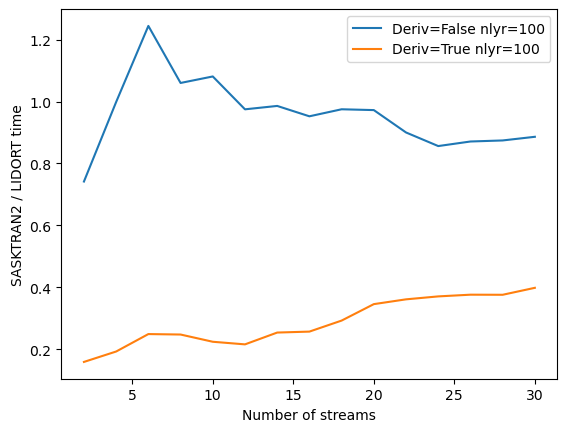

In [5]:

for nlyr in [100]:
    for deriv in [False, True]:
        streams = np.arange(2, 32, 2)
        sk2_t = np.zeros(len(streams))
        lidort_t = np.zeros(len(streams))

        for i, ns in enumerate(streams):
            sk2_t[i] = time_sk2(nlyr, ns, deriv).average
            lidort_t[i] = time_lidort(nlyr, ns, deriv).average

        plt.plot(streams, sk2_t / lidort_t, label=f"Deriv={deriv} nlyr={nlyr}")

plt.legend()
plt.xlabel("Number of streams")
plt.ylabel("SASKTRAN2 / LIDORT time")

In [ ]:
sk2_t

array([0.0223797 , 0.29097287, 0.90317067, 1.87306367, 3.80799733])

In [ ]:
time_sk2(200, 40, True)

: 

In [9]:
time_sk2(100, 2, True)

58.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


<TimeitResult : 58.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)>

In [2]:
time_lidort(100, 16, True)

3.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 3.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>